In [14]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import matplotlib.pyplot as plt

# Register custom metrics
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-6) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1e-6)

@tf.keras.utils.register_keras_serializable()
def iou_coef(y_true, y_pred):
    intersection = tf.keras.backend.sum(y_true * y_pred)
    union = tf.keras.backend.sum(y_true) + tf.keras.backend.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

# Load your pre-trained U-Net model with custom metrics
custom_objects = {"dice_coef": dice_coef, "iou_coef": iou_coef}
unet_model = load_model('best_unet_custom.keras', custom_objects=custom_objects)

# Symptom weights and thresholds
symptom_weights = {
    'Rectal Pain': 10,
    'Sore Throat': 5,
    'Penile Oedema': 8,
    'Oral Lesions': 12,
    'Solitary Lesion': 7,
    'Swollen Tonsils': 6,
    'HIV Infection': 15,
    'Sexually Transmitted Infection': 10,
    'Systemic Illness_Fever': 10,
    'Systemic Illness_Muscle Aches and Pain': 8,
    'Systemic Illness_Swollen Lymph Nodes': 12,
    'Systemic Illness_n/a': 0
}

# Severity thresholds and normalization factors
T1, T2, T3 = 25, 50, 75
alpha, beta = 0.6, 0.4
gamma, delta = 0.5, 0.5
N_max, A_max = 25, 100

# Function to calculate symptom severity score
def calculate_symptom_score(symptoms, symptom_weights):
    S_symptoms = sum(int(symptoms[symptom]) * symptom_weights[symptom] for symptom in symptoms)
    return (S_symptoms / sum(symptom_weights.values())) * 100

# Function to calculate lesion metrics
def calculate_lesion_size(predicted_mask, threshold=0.5):
    predicted_mask = np.clip(predicted_mask, 0, 1)
    binary_mask = (predicted_mask > threshold).astype(np.uint8)
    num_labels, labels_im = cv2.connectedComponents(binary_mask)
    lesion_sizes = [np.sum(labels_im == label) for label in range(1, num_labels)]
    total_lesion_area = np.sum(lesion_sizes)
    return total_lesion_area, num_labels - 1, lesion_sizes

# Function to calculate image severity score
def calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta):
    S_image = alpha * (num_lesions / N_max) + beta * (total_lesion_area / A_max)
    return S_image * 100

# Function to calculate final severity score
def calculate_final_score(S_symptoms, S_image, gamma, delta):
    return gamma * S_symptoms + delta * S_image

# Function to determine severity level
def determine_severity_level(S_final, T1, T2, T3):
    if S_final < T1:
        return "Mild"
    elif T1 <= S_final < T2:
        return "Moderate"
    elif T2 <= S_final < T3:
        return "Severe"
    else:
        return "Serious"

# Function to process patient data and calculate severity
def process_patient_data(image, symptoms, unet_model):
    # Predict lesion mask
    image_resized = cv2.resize(image, (224, 224))  # Resize image to match model input
    predicted_mask = unet_model.predict(np.expand_dims(image_resized , axis=0))[0]
    
    # Calculate lesion metrics
    total_lesion_area, num_lesions, _ = calculate_lesion_size(predicted_mask)
    
    # Calculate scores
    S_symptoms = calculate_symptom_score(symptoms, symptom_weights)
    S_image = calculate_image_score(total_lesion_area, num_lesions, N_max, A_max, alpha, beta)
    S_final = calculate_final_score(S_symptoms, S_image, gamma, delta)
    
    # Determine severity level
    severity_level = determine_severity_level(S_final, T1, T2, T3)
    
    return S_symptoms, S_image, S_final, severity_level

# Example patient data
symptoms = {
    'Rectal Pain': True,
    'Sore Throat': False,
    'Penile Oedema': False,
    'Oral Lesions': True,
    'Solitary Lesion': False,
    'Swollen Tonsils': False,
    'HIV Infection': False,
    'Sexually Transmitted Infection': False,
    'Systemic Illness_Fever': True,
    'Systemic Illness_Muscle Aches and Pain': True,
    'Systemic Illness_Swollen Lymph Nodes': False,
    'Systemic Illness_n/a': False
}

# Load example image
image = cv2.imread('mkp_093.jpg')  # Replace with actual image path

# Process patient data
S_symptoms, S_image, S_final, severity_level = process_patient_data(image, symptoms, unet_model)

# Display results
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Symptom-Based Severity Score: 38.83
Image-Based Severity Score: 2173.60
Final Severity Score: 1106.22
Severity Level: Serious


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step


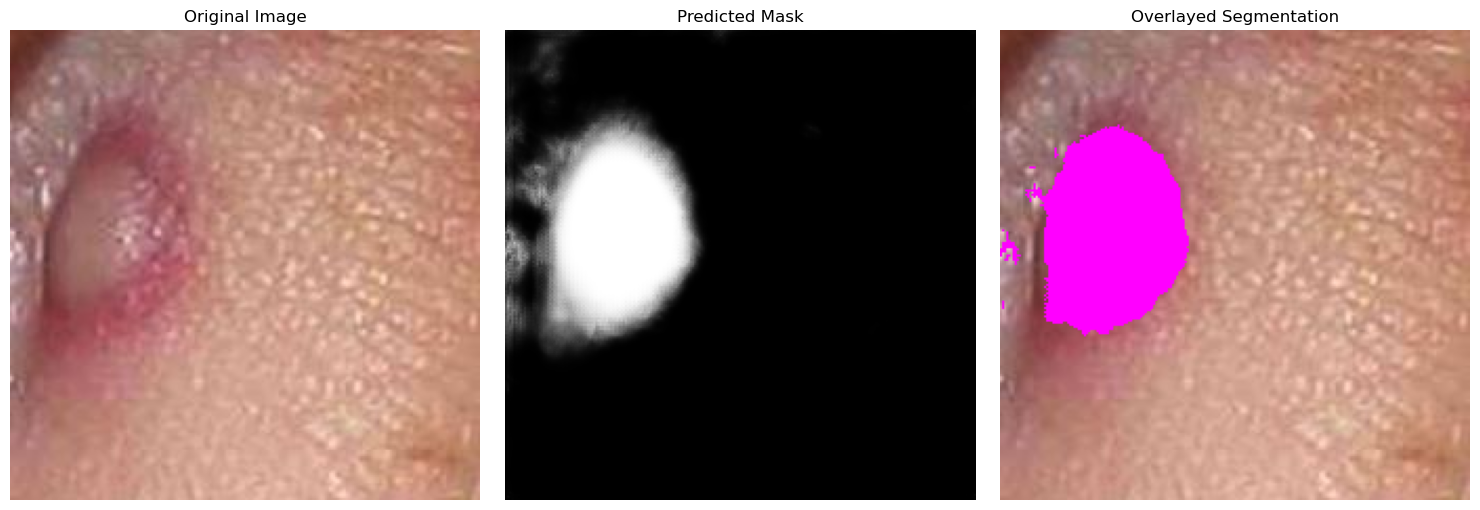

Symptom-Based Severity Score: 38.83
Image-Based Severity Score: 2173.60
Final Severity Score: 1106.22
Severity Level: Serious


In [15]:
def visualize_results(image, predicted_mask, threshold=0.5):
    """
    Visualizes the original image, predicted mask, and overlay of the segmentation.
    """
    # Resize predicted mask to match original image dimensions
    predicted_mask_resized = cv2.resize(predicted_mask, (image.shape[1], image.shape[0]))
    binary_mask = (predicted_mask_resized > threshold).astype(np.uint8)

    # Overlay mask on the original image
    overlay = image.copy()
    overlay[binary_mask == 1] = [255, 0, 255]  # Green overlay for segmentation
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask_resized, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Overlayed Segmentation")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Process patient data and visualize
S_symptoms, S_image, S_final, severity_level = process_patient_data(image, symptoms, unet_model)

# Predict lesion mask for visualization
image_resized = cv2.resize(image, (224, 224))  # Resize to model input dimensions
predicted_mask = unet_model.predict(np.expand_dims(image_resized , axis=0))[0]

# Visualize results
visualize_results(image, predicted_mask)

# Display severity scores
print(f"Symptom-Based Severity Score: {S_symptoms:.2f}")
print(f"Image-Based Severity Score: {S_image:.2f}")
print(f"Final Severity Score: {S_final:.2f}")
print(f"Severity Level: {severity_level}")
